## Enunciado questão
A financeira FMG realiza mensalmente a concessão de crédito pessoal para seus clientes. Para manter a saúde financeira de suas operações, a taxa de inadimplência esperada de cada safra 6 meses após a concessão não pode ser superior a 5,0%.
Foi solicitado que você realize uma revisão na política atual de concessão. Para realizar esta tarefa, foram fornecidos os dados de clientes de 5 meses que realizaram contratações de crédito entre janeiro e maio de 2022 (aba "DADOS"), com a indicação de quem esteve inadimplente no contrato 6 meses após a contratação. A sugestão inicial é que a política de crédito considere que as aprovações de propostas acontecem considerando o score de crédito dos clientes, sendo que clientes com score superior a 600 são aprovados, e clientes com score até 500 são negados.

Considerando as informações acima, a política de crédito inicialmente sugerida é eficiente? É possível aumentar a concessão sem ferir o apetite de inadimplência?
Caso entenda não ser eficiente, elabore uma nova proposta de política para apresentar à gestão do FMG. 


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
from collections import Counter

warnings.filterwarnings("ignore") 

# pd.set_option()

# https://medium.com/@natalia.gcvs/regress%C3%A3o-log%C3%ADstica-uma-vis%C3%A3o-geral-de-uma-t%C3%A9cnica-de-classifica%C3%A7%C3%A3o-bin%C3%A1ria-eba0a4a06518
# 1 = indadimplente (evento)
# 0 = adimplente (nao evento)
# fazer quantidade de operações por mês como analise descritiva também ( da para fazer um grafico)
# quantidade de operações por genero, localizacao...
# https://www.youtube.com/watch?v=lK8ANM7VkNU , ideia de fazer um novo score-credito

# Importação e tratamento dos dados

In [257]:
df = pd.read_excel('dados_case.xlsx', sheet_name='dados')
df2 = df.copy()
df2.head(10)

df2['Safra'] = pd.to_datetime(df2['Safra'].astype(str), format='%Y%m')
df2['Safra'] = df2['Safra'].dt.strftime('%Y-%m-%d') 

for i in df.columns:
    resultado = df2[i].isna().unique()
    print(f"'{i}' apresenta valores faltantes: {resultado}")

'Cliente' apresenta valores faltantes: [False]
'Safra' apresenta valores faltantes: [False]
'idade' apresenta valores faltantes: [False]
'genero' apresenta valores faltantes: [False]
'renda' apresenta valores faltantes: [False]
'Score_de_credito' apresenta valores faltantes: [False]
'localizacao' apresenta valores faltantes: [False]
'nivel_escolaridade' apresenta valores faltantes: [False]
'contas_bancarias' apresenta valores faltantes: [False]
'Contratos' apresenta valores faltantes: [False]
'Faixa_renda' apresenta valores faltantes: [False]
'Faixa_idade' apresenta valores faltantes: [False]
'Faixa_Score' apresenta valores faltantes: [False]
'Atraso_apos_6meses' apresenta valores faltantes: [False]


# Sem correlação nas variáveis independentes, ou seja, sem multicolinearidade

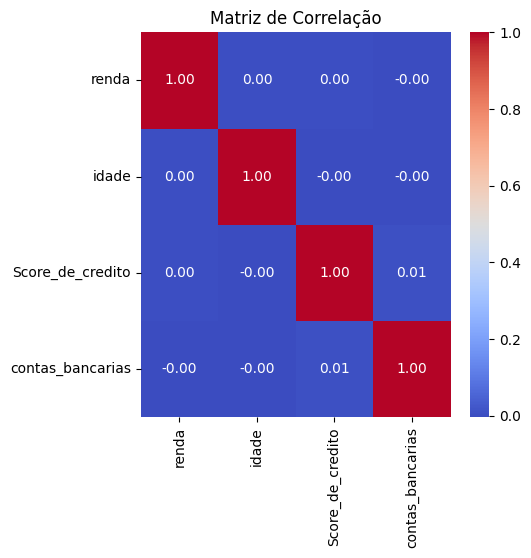

In [182]:
matriz = df2[['renda','idade','Score_de_credito','contas_bancarias']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

# Análise da Taxa de Inadimplência Atual
### Considerando atraso apos 6 meses de contrato:
.: Taxa de 6.65%, portanto superior a 5% concluindo que está prejudicial para a saúde operacional da empresa.


In [232]:
total_linhas = len(df2)
total_atraso = len(df2[df2['Atraso_apos_6meses']==1])

tx_atual = total_atraso/total_linhas

print(f"Taxa de inadimplencia hoje: {tx_atual*100}%")

Taxa de inadimplencia hoje: 6.65%


### Considerando o score de crédito
 - maior que 600 = aprovado
 - menor ou igual a 500 = nao aprovado

In [234]:
tx_df2_600 = len(df2[(df2['Score_de_credito']>600) & (df2['Atraso_apos_6meses']==1)]) / len(df2[(df2['Score_de_credito']>600)])
tx_df2_500 = len(df2[(df2['Score_de_credito']<=500) & (df2['Atraso_apos_6meses']==1)]) / len(df2[(df2['Score_de_credito']<=500)])

print(f"Taxa de inadimplencia com score acima de 600: {tx_df2_600 * 100:.4f} %")
print(f"Taxa de inadimplencia com score 500 ou menor: {tx_df2_500 * 100:.4f} %")

Taxa de inadimplencia com score acima de 600: 4.8711 %
Taxa de inadimplencia com score 500 ou menor: 8.5963 %


Esses dados indicam que, conforme a pontuação de crédito do cliente aumenta, a taxa de inadimplência diminui, o que é esperado. Isso sugere que a política atual (aprovando clientes com score superior a 600 e negando os com score abaixo de 500) PODE SER razoavelmente eficiente.

# Nova política de crédito

# Reg Logística
- A regressão logística, ao contrário da regressão linear, é usada para problemas de classificação binária, ou seja, para prever uma variável dependente categórica com dois resultados possíveis. Em vez de prever um valor contínuo, a regressão logística prevê a probabilidade de um evento acontecer, onde a saída está entre 0 e 1.
- O logit é a função de link usada na regressão logística. Em termos simples, o logit é a transformação da probabilidade em uma escala contínua (usando a função logarítmica das odds), para que possamos usar uma regressão linear para modelar a relação entre as variáveis independentes (ou preditores) e a variável dependente.
- Ou seja, a função logística transforma o logit (que pode ser qualquer valor real) em uma probabilidade entre 0 e 1.
- Coeficientes:
    - O coeficiente de cada variável no modelo logístico (como genero_Masculino, nivel_escolaridade_Médio, etc.) indica o impacto de cada variável na log-odds (logaritmo das odds) do evento.
    - Coeficiente positivo: Significa que o aumento da variável aumenta a probabilidade do evento acontecer.
    - Coeficiente negativo: Significa que o aumento da variável diminui a probabilidade do evento acontecer.

- Logit se calcula na regressão logística:
    - logit(p)=β0 +β1⋅x1 +β2⋅x2+...+βn⋅xn

- Com o logit jogo na função logística (sigmoide):
    - p= 1 / 1 + e^−logit(p)

Exemplo:
- 𝑥1: é a idade do cliente (por exemplo, 30 anos)
- 𝑥2: é o score de crédito do cliente (por exemplo, 600)

Logit:
- logit(p)=0.5+6−180=−173.5 , onde 0.5 é o corte

Função logística para calcular a probabilidade:
- p= 1 / 1+e^−(−173.5) ≈ 1 / 1+e^ 173.5 ≈ 0

Portanto, a probabilidade é mto próximo de 0, indicando que o cliente seria adimplente

​


## SMOTE

- Quando temos um conjunto de dados em que uma classe é muito mais prevalente do que a outra (por exemplo, em um problema de classificação binária onde 90% dos dados são da classe negativa e 10% da classe positiva), o modelo pode tender a ignorar (o modelo aprende a ignorar) a classe minoritária (a classe com menos exemplos), levando a um desempenho ruim ao prever essa classe.

In [269]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cliente             10000 non-null  int64  
 1   Safra               10000 non-null  object 
 2   idade               10000 non-null  int64  
 3   genero              10000 non-null  object 
 4   renda               10000 non-null  float64
 5   Score_de_credito    10000 non-null  int64  
 6   localizacao         10000 non-null  object 
 7   nivel_escolaridade  10000 non-null  object 
 8   contas_bancarias    10000 non-null  int64  
 9   Contratos           10000 non-null  int64  
 10  Faixa_renda         10000 non-null  object 
 11  Faixa_idade         10000 non-null  object 
 12  Faixa_Score         10000 non-null  object 
 13  Atraso_apos_6meses  10000 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


## Desbalanceamento da variável dependente
- necessidade de balanceamento para que o modelo não 'aprenda' a ignorar a classe com menos observações.
- Será usado o método SMOTE: o SMOTE cria novos exemplos da classe minoritária com base nos exemplos existentes (Ex: distância Euclidiana), o que ajuda o modelo a aprender melhor as características da classe minoritária.

In [242]:
df2['Atraso_apos_6meses'].value_counts()

Atraso_apos_6meses
0    9335
1     665
Name: count, dtype: int64

In [17]:
# colunas numéricas e categóricas
# numeric_features   = ['renda','idade','Score_de_credito','contas_bancarias']
# categorical_feats  = ['genero', 'localizacao', 'nivel_escolaridade']
numeric_features   = ['contas_bancarias']
categorical_feats  = ['genero', 'localizacao', 'nivel_escolaridade', 'Faixa_renda', 'Faixa_idade', 'Faixa_Score']


# Monte o “pipeline” de pré-processamento
preprocessor = ColumnTransformer([
    ('n', MinMaxScaler(), numeric_features),
    ('c', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), categorical_feats),
])

# treino e teste
var_x = df2[numeric_features + categorical_feats]
var_y = df2['Atraso_apos_6meses']
var_x_treino, var_x_teste, var_y_treino, var_y_teste = train_test_split(
    var_x, var_y, test_size=0.2, random_state=123, stratify=var_y
)

# aplicando normalização e dummização
var_x_treino_p = preprocessor.fit_transform(var_x_treino)
var_x_teste_p  = preprocessor.transform(var_x_teste)

# SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=123)
X_train_res, y_train_res = smote.fit_resample(var_x_treino_p, var_y_treino)

# nomes das variáveis transformadas
nome_variaveis = preprocessor.get_feature_names_out()

# Tabela resumo para statsmodels e intercepto
X_train_sm = pd.DataFrame(X_train_res, columns=nome_variaveis)
X_train_sm = sm.add_constant(X_train_sm)

# modelo Logit
reg_logistica = sm.Logit(y_train_res, X_train_sm).fit(disp=False)

# coeficientes e p-valores
reg_logistica.summary2().tables[1]


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.567964,0.090596,6.269190,3.629301e-10,0.390399,0.745529
n__contas_bancarias,-0.112778,0.050313,-2.241538,2.499126e-02,-0.211389,-0.014167
c__genero_Masculino,0.162199,0.034844,4.655000,3.239810e-06,0.093906,0.230493
c__localizacao_Norte,0.005818,0.059067,0.098496,9.215382e-01,-0.109952,0.121587
c__localizacao_Oeste,0.076107,0.054597,1.393990,1.633205e-01,-0.030900,0.183115
c__localizacao_Sul,-0.030142,0.062372,-0.483268,6.289053e-01,-0.152388,0.092104
c__nivel_escolaridade_Médio,-0.208041,0.052133,-3.990570,6.591470e-05,-0.310221,-0.105862
c__nivel_escolaridade_Pós-graduação,-0.584570,0.043189,-13.535119,9.702575e-42,-0.669219,-0.499921
c__nivel_escolaridade_Superior,-0.505442,0.058129,-8.695138,3.464083e-18,-0.619374,-0.391511
c__Faixa_renda_4001-6000,-0.271105,0.052541,-5.159852,2.471457e-07,-0.374083,-0.168126


In [26]:
for col in df2.columns:
    resultado = df2[col].value_counts()
    print(resultado)



Cliente
10000    1
1        1
2        1
3        1
4        1
        ..
20       1
21       1
22       1
23       1
24       1
Name: count, Length: 10000, dtype: int64
Safra
202205    2278
202202    2193
202203    2060
202201    1824
202204    1645
Name: count, dtype: int64
idade
55    226
33    223
26    222
53    217
58    217
34    216
23    212
70    207
45    203
25    202
59    198
68    197
41    195
42    195
36    195
24    195
43    192
57    192
30    191
47    190
65    190
32    190
38    189
39    189
63    188
46    187
18    187
54    186
37    186
40    186
61    185
50    184
29    183
66    182
51    182
56    179
19    179
67    178
69    177
28    176
64    175
22    175
60    174
44    174
48    174
62    173
52    173
21    172
31    172
49    171
27    171
35    168
20    160
Name: count, dtype: int64
genero
Masculino    5136
Feminino     4864
Name: count, dtype: int64
renda
9958.77    2
8781.02    2
4083.64    2
5136.70    2
1414.64    2
          ..
2911.03 

In [ ]:
# colunas numéricas e categóricas
# numeric_features   = ['renda','idade','Score_de_credito','contas_bancarias']
# categorical_feats  = ['genero', 'localizacao', 'nivel_escolaridade']
numeric_features   = ['contas_bancarias']
categorical_feats  = ['genero', 'localizacao', 'nivel_escolaridade', 'Faixa_renda', 'Faixa_idade', 'Faixa_Score']


# Monte o “pipeline” de pré-processamento
preprocessor = ColumnTransformer([
    ('n', MinMaxScaler(), numeric_features),
    ('c', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), categorical_feats),
])

# treino e teste
var_x = df2[numeric_features + categorical_feats]
var_y = df2['Atraso_apos_6meses']
var_x_treino, var_x_teste, var_y_treino, var_y_teste = train_test_split(
    var_x, var_y, test_size=0.2, random_state=123, stratify=var_y
)

# aplicando normalização e dummização
var_x_treino_p = preprocessor.fit_transform(var_x_treino)
var_x_teste_p  = preprocessor.transform(var_x_teste)

# SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=123)
X_train_res, y_train_res = smote.fit_resample(var_x_treino_p, var_y_treino)

# nomes das variáveis transformadas
nome_variaveis = preprocessor.get_feature_names_out()

# Tabela resumo para statsmodels e intercepto
X_train_sm = pd.DataFrame(X_train_res, columns=nome_variaveis)
X_train_sm = sm.add_constant(X_train_sm)

# modelo Logit
reg_logistica = sm.Logit(y_train_res, X_train_sm).fit(disp=False)

# coeficientes e p-valores
reg_logistica.summary2().tables[1]


### Coeficientes Significativos (p-valor < 0.05):
**genero_Masculino**: O coeficiente positivo indica que os clientes do gênero masculino têm uma probabilidade ligeiramente maior de ser inadimplentes em comparação com as clientes do gênero feminino. Essa variável, portanto, tem um impacto positivo na probabilidade de inadimplência.

**nivel_escolaridade_Médio**, **nivel_escolaridade_Superior** e **nivel_escolaridade_Pós-graduação** : O coeficiente negativo sugere que clientes com nível de escolaridade médio, superior ou pós-graduação têm uma probabilidade consideravelmente menor de inadimplência. Isso sugere que o nível de escolaridade pode ser um bom preditor de menor risco de inadimplência

**Faixa_renda_Até 2000**, **Faixa_renda_4001-6000** e **Faixa_renda_6001-10000**: Essas faixas de renda têm coeficientes negativos, indicando que clientes com renda mais alta têm uma probabilidade menor de inadimplência. Isso é consistente com a ideia de que clientes com maior renda podem ser menos arriscados.

**Faixa_Score_501-600**, **Faixa_Score_601-700**, **Faixa_Score_701-800**, **Faixa_Score_801-850**: Todas essas faixas de score de crédito têm coeficientes negativos, o que indica que quanto maior o score de crédito, menor a probabilidade de inadimplência. Isso confirma que o score de crédito é um dos principais preditores de inadimplência, como esperado em políticas de crédito.

**Faixa_idade_36-50** e **Faixa_idade_51-70**: Essas faixas de idade têm coeficientes positivos, indicando que clientes dessas faixas etárias têm uma probabilidade maior de inadimplência. Isso sugere que a faixa etária pode ter um impacto no risco de inadimplência, com clientes mais velhos possivelmente sendo mais arriscados.

**Resumo**
Score de crédito e renda são preditores significativos de inadimplência, com scores mais baixos e rendas mais altas associados a uma maior chance de inadimplência.

A escolaridade, especialmente pós-graduação, está negativamente associada à inadimplência, indicando que clientes com maior nível de escolaridade são menos propensos a serem inadimplentes.

Faixa etária e localização têm menos impacto na previsão de inadimplência


Threshold: 0.4
Precisão: 0.08
Recall: 0.80


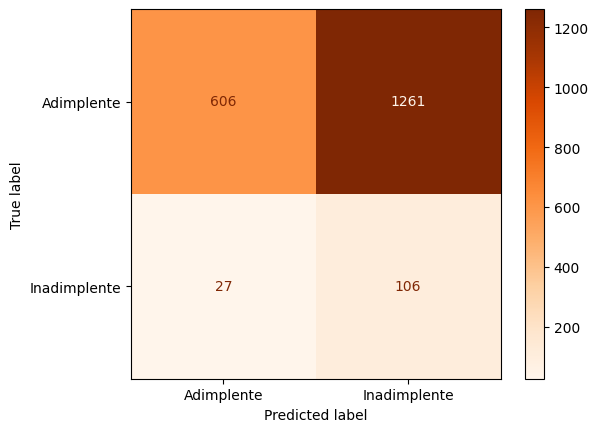

In [34]:
# Para rodar predições e avaliar no teste:
X_test_sm = pd.DataFrame(var_x_teste_p, columns=nome_variaveis, index=var_x_teste.index)
X_test_sm = sm.add_constant(X_test_sm)
y_pred_proba = reg_logistica.predict(X_test_sm)

corte = 0.4
y_pred = (y_pred_proba >= corte).astype(int)

conf_matrix = confusion_matrix(var_y_teste, y_pred)
precision = precision_score(var_y_teste, y_pred)
recall = recall_score(var_y_teste, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=["Adimplente", "Inadimplente"]).plot(cmap='Oranges', values_format='d')

print(f"Threshold: {corte}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")

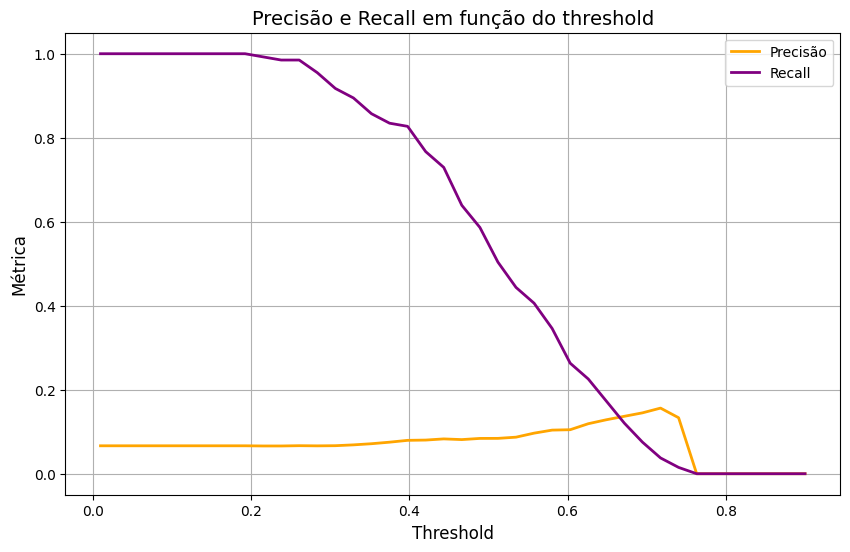

In [254]:
thresholds = np.linspace(0.01, 0.9, 40)

precisions = []
recalls = []

for corte in thresholds:
    y_pred = (y_pred_proba >= corte).astype(int) 
    
    # matriz de confusão
    conf_matrix = confusion_matrix(var_y_teste, y_pred)
    
    #  precisão e recall
    precision = precision_score(var_y_teste, y_pred)
    recall = recall_score(var_y_teste, y_pred)
    precisions.append(precision)
    recalls.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precisão', color='orange', linestyle='-', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', color='purple', linestyle='-', linewidth=2)

plt.title('Precisão e Recall em função do threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Métrica', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Ajuste do Threshold
A relação entre o ajuste do corte (threshold) e a política de crédito de um banco está diretamente ligada à decisão de conceder crédito (ou não) a um cliente, e isso impacta diretamente a precisão (precision) e o recall do modelo. 

Exemplo: Se o threshold for 0.5:

- Se a probabilidade de inadimplência de um cliente for maior ou igual a 0.5, o modelo classifica como inadimplente (1).
- Se for menor que 0.5, classifica como não inadimplente (0).

Mas o threshold pode ser ajustado. Por exemplo:

Threshold baixo (Banco mais conservador):
- Aumento do Recall: Mais clientes inadimplentes serão identificados.
- Redução da Precisão: O banco pode erroneamente aprovar mais clientes como inadimplentes, aumentando a taxa de falsos positivos (clientes não inadimplentes classificados como inadimplentes).

Threshold alto (Banco arriscando mais):
- Aumento da Precisão: Menos clientes serão classificados como inadimplentes, aumentando a precisão porque as previsões positivas do modelo serão mais confiáveis.
- Redução do Recall: O modelo pode deixar de identificar alguns inadimplentes reais (aumentando os falsos negativos).

# Simulação de input de um novo cliente

In [289]:
# Coeficientes do modelo que são estatisticamente significativos
coef = {
    'const': 0.567964,
    'genero_Masculino': 0.162199,
    'nivel_escolaridade_Médio': -0.208041,
    'nivel_escolaridade_Pós-graduação': -0.584570,
    'Faixa_renda_4001-6000': -0.271105,
    'Faixa_renda_6001-10000': -0.226520,
    'Faixa_renda_Até 2000': -0.192529,
    'Faixa_idade_36-50': 0.338755,
    'Faixa_idade_51-70': 0.302021,
    'Faixa_Score_501-600': -0.364174,
    'Faixa_Score_601-700': -0.685427,
    'Faixa_Score_701-800': -0.838719,
    'Faixa_Score_801-850': -0.961575,
    'Faixa_Score_Até 400': 0.117366}

# Colocar 1 se for característica do novo cliente, senao preencher 0
novo_cliente = {
    'genero_Masculino': 1,                  
    'nivel_escolaridade_Médio': 0,          
    'nivel_escolaridade_Pós-graduação': 1,  
    'Faixa_renda_4001-6000': 0,             
    'Faixa_renda_6001-10000': 1,            
    'Faixa_renda_Até 2000': 0,              
    'Faixa_idade_36-50': 0,                 
    'Faixa_idade_51-70': 0,                 
    'Faixa_Score_501-600': 0,               
    'Faixa_Score_601-700': 0,               
    'Faixa_Score_701-800': 0,               
    'Faixa_Score_801-850': 1,               
    'Faixa_Score_Até 400': 0}

# logit(p)
logit = coef['const']
for feature, value in novo_cliente.items():
    if feature in coef:
        logit += coef[feature] * value

# probabilidade de inadimplência
probabilidade = 1 / (1 + np.exp(-logit))

# Exibir a probabilidade de inadimplência
print(f"Probabilidade de inadimplência do novo cliente: {probabilidade*100:.4}%")

# Threshold para classificar como inadimplente ou adimplente
threshold = 0.4
classe = 1 if probabilidade >= threshold else 0
if classe == 1:
    print("O novo cliente será INADIMPLENTE.")
else:
    print("O novo cliente será ADIMPLENTE.")

Probabilidade de inadimplência do novo cliente: 50.91%
O novo cliente será INADIMPLENTE.


### Comparação das políticas

**Política Atual**:
- Aprovação para clientes com score de crédito superior a 600.
- Recusa para clientes com score de crédito igual ou abaixo de 500.

Pode-se ajustá-la levando em conta outras variáveis significativas identificadas na análise.

**Política Proposta**:
- Considerar mais faixas de score:
    - Para clientes com score de 501-600, 601-700, 701-800, e 801-850, a probabilidade de inadimplência é mais baixa, e esses clientes podem ser mais facilmente aprovados com menor risco de inadimplência.
    - Isso sugere que a política de aprovados com score acima de 600 poderia ser expandida para incluir faixas adicionais.

- Considerar o nível de escolaridade:
    - Clientes principalmente com pós-graduação apresentam uma probabilidade significativamente menor de inadimplência, portanto, podem ser priorizados na concessão de crédito.
    - Clientes com nível médio e superior também mostram uma tendência a pagar suas dívidas com mais frequência, e podem ser incluídos em uma faixa de risco menor.

- Considerar a idade:
    - Clientes com idades entre 36 e 50 anos e 51 a 70 anos podem representar um risco financeiro maior, exigindo um ajuste nas condições de crédito. Esses grupos podem ser mais propensos a dificuldades de pagamento.

### Conclusão / Melhorias
- Incorporando variáveis adicionais como faixas de score, faixa de renda e nível de escolaridade, pode-se aumentar a concessão de crédito sem aumentar o risco de inadimplência.


In [3]:
# Coeficientes do modelo de regressão logística
coef = {
    'const': 0.567964,
    'genero_Masculino': 0.162199,
    'nivel_escolaridade_Médio': -0.208041,
    'nivel_escolaridade_Pós-graduação': -0.584570,
    'Faixa_renda_4001-6000': -0.271105,
    'Faixa_renda_6001-10000': -0.226520,
    'Faixa_renda_Até 2000': -0.192529,
    'Faixa_idade_36-50': 0.338755,
    'Faixa_idade_51-70': 0.302021,
    'Faixa_Score_501-600': -0.364174,
    'Faixa_Score_601-700': -0.685427,
    'Faixa_Score_701-800': -0.838719,
    'Faixa_Score_801-850': -0.961575,
    'Faixa_Score_Até 400': 0.117366
}

# Função para calcular a probabilidade de inadimplência
def calcular_probabilidade(cliente_info, coef):
    logit = coef['const']
    for feature, value in cliente_info.items():
        if feature in coef:
            logit += coef[feature] * value
    probabilidade = 1 / (1 + np.exp(-logit))  # Função logística
    return probabilidade

# Definindo as faixas de score de crédito e criando as entradas do cliente para cada faixa
faixas_score = ['Até 400', '401-600', '601-700', '701-800', '801-850']
resultados = []

for faixa in faixas_score:
    # Criar o dicionário de variáveis para cada faixa de score
    novo_cliente = {
        'genero_Masculino': 0,  # Alterar conforme necessário
        'nivel_escolaridade_Médio': 0,  # Alterar conforme necessário
        'nivel_escolaridade_Pós-graduação': 0,  # Alterar conforme necessário
        'Faixa_renda_4001-6000': 0,  # Alterar conforme necessário
        'Faixa_renda_6001-10000': 0,  # Alterar conforme necessário
        'Faixa_renda_Até 2000': 0,  # Alterar conforme necessário
        'Faixa_idade_36-50': 0,  # Alterar conforme necessário
        'Faixa_idade_51-70': 0,  # Alterar conforme necessário
        'Faixa_Score_501-600': 0,  # Alterar conforme necessário
        'Faixa_Score_601-700': 0,  # Alterar conforme necessário
        'Faixa_Score_701-800': 0,  # Alterar conforme necessário
        'Faixa_Score_801-850': 0,  # Alterar conforme necessário
        'Faixa_Score_Até 400': 0  # Alterar conforme necessário
    }
    
    # Atribuindo 1 à faixa correspondente
    novo_cliente[f'Faixa_Score_{faixa}'] = 1
    
    # Calcular a probabilidade de inadimplência para cada faixa de score
    probabilidade = calcular_probabilidade(novo_cliente, coef)
    
    # Adicionar o resultado à lista
    resultados.append({
        'Faixa de Score': faixa,
        'Probabilidade de Inadimplência': probabilidade
    })

# Converter os resultados em um DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibir a tabela de resultados
print(df_resultados)

  Faixa de Score  Probabilidade de Inadimplência
0        Até 400                        0.664927
1        401-600                        0.638293
2        601-700                        0.470668
3        701-800                        0.432722
4        801-850                        0.402848


# SMOTE teste

In [ ]:
# Carregar o DataFrame com seus dados
df2 = pd.read_excel('dados_case.xlsx', sheet_name='dados')

# Colunas numéricas e categóricas
numeric_features = ['contas_bancarias']
categorical_feats = ['genero', 'localizacao', 'nivel_escolaridade', 'Faixa_renda', 'Faixa_idade', 'Faixa_Score']

# Preparação dos dados
var_x = df2[numeric_features + categorical_feats]
var_y = df2['Atraso_apos_6meses']

# Dividir os dados em treino e teste
var_x_treino, var_x_teste, var_y_treino, var_y_teste = train_test_split(var_x, var_y, test_size=0.2, random_state=123, stratify=var_y)

smote = SMOTE(sampling_strategy='auto', random_state=123)
X_train_res, y_train_res = smote.fit_resample(var_x_treino[numeric_features], var_y_treino)

X_train_res_combined = pd.concat([pd.DataFrame(X_train_res, columns=numeric_features), var_x_treino[categorical_feats].reset_index(drop=True)], axis=1)

# Pipeline de pré-processamento (apenas para normalização e one-hot encoding)
preprocessor = ColumnTransformer([
    ('n', MinMaxScaler(), numeric_features),  # Normalizar variáveis numéricas
    ('c', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), categorical_feats),  # One-hot encoding para variáveis categóricas
])

# Aplicando o pré-processamento nas variáveis numéricas e categóricas (após SMOTE)
X_train_res_p = preprocessor.fit_transform(X_train_res_combined)
X_test_p = preprocessor.transform(var_x_teste)

# Treinamento do modelo Logit com SMOTE nos dados balanceados
logit_model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
logit_model.fit(X_train_res_p, y_train_res)

# **Validação Cruzada**:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Realizando a validação cruzada com o modelo de regressão logística
resultados = cross_validate(logit_model, X_train_res_p, y_train_res, cv=folds, scoring=scoring, return_train_score=False)

# Exibir os resultados da validação cruzada
print("Resultados da Validação Cruzada:")
print(f"Accuracy: {resultados['test_accuracy'].mean():.4f} ± {resultados['test_accuracy'].std():.4f}")
print(f"Precision: {resultados['test_precision'].mean():.4f} ± {resultados['test_precision'].std():.4f}")
print(f"Recall: {resultados['test_recall'].mean():.4f} ± {resultados['test_recall'].std():.4f}")
print(f"F1-Score: {resultados['test_f1'].mean():.4f} ± {resultados['test_f1'].std():.4f}")

# Predições no conjunto de teste
y_pred_proba = logit_model.predict_proba(X_test_p)[:, 1]  # Probabilidade da classe 1 (inadimplente)
y_pred = (y_pred_proba >= 0.4).astype(int)  # Definindo o threshold

# Matriz de Confusão
conf_matrix = confusion_matrix(var_y_teste, y_pred)

# Exibir a matriz de confusão com visualização
ConfusionMatrixDisplay(conf_matrix, display_labels=["Adimplente", "Inadimplente"]).plot(cmap='Oranges', values_format='d')

# Calcular e exibir precisão e recall
precision = precision_score(var_y_teste, y_pred)
recall = recall_score(var_y_teste, y_pred)

print(f"Threshold: 0.4")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# OLS

In [70]:
# 1) Defina colunas numéricas e categóricas
numeric_features   = ['contas_bancarias']
categorical_feats  = ['genero', 'localizacao', 'nivel_escolaridade','Faixa_renda', 'Faixa_idade', 'Faixa_Score']

# 2) Monte o pré-processador
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),
    categorical_feats),
])

# 3) Separe X e y (target contínuo: Score_de_credito)
X = df2[numeric_features + categorical_feats]
y = df2['Score_de_credito']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# 4) Aplique o pré-processador
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# 5) Recupere nomes das variáveis transformadas
feat_names = preprocessor.get_feature_names_out()

# 6) Monte DataFrame para statsmodels e adicione intercepto
X_train_sm = pd.DataFrame(X_train_proc, columns=feat_names, index=X_train.index)
X_train_sm = sm.add_constant(X_train_sm)

# 7) Ajuste do modelo OLS
ols_sm = sm.OLS(y_train, X_train_sm).fit()

# 8) Exiba o summary com coeficientes, erros-padrão, t-stats e p-valores
print(ols_sm.summary2())

                             Results: Ordinary least squares
Model:                      OLS                     Adj. R-squared:            0.969     
Dependent Variable:         Score_de_credito        AIC:                       75960.4576
Date:                       2025-06-20 14:39        BIC:                       76100.2016
No. Observations:           8000                    Log-Likelihood:            -37960.   
Df Model:                   19                      F-statistic:               1.325e+04 
Df Residuals:               7980                    Prob (F-statistic):        0.00      
R-squared:                  0.969                   Scale:                     776.41    
-----------------------------------------------------------------------------------------
                                       Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------------------------------
const                                 4

# Inputando novos clientes e tentando prever o score_credito

In [ ]:
novo_cliente = pd.DataFrame([{
    'contas_bancarias':    1,
    'genero':             'Masculino',
    'localizacao':        'Sul',
    'nivel_escolaridade': 'Médio',
    'Faixa_renda':        '6001-10000',
    'Faixa_idade':        '36-50',
    'Faixa_Score':        '801-850'
}])

X_novo_proc = preprocessor.transform(novo_cliente)

X_novo_df = pd.DataFrame(X_novo_proc, columns=feat_names, index=novo_cliente.index)
X_novo_df = sm.add_constant(X_novo_df, has_constant='add')

score_predito = ols_sm.predict(X_novo_df)
print(f"Score previsto: {score_predito.iloc[0]:.2f}")

# Comparando modelos

In [104]:
df = pd.read_excel('dados_case.xlsx', sheet_name='dados')

# 1) Defina X, y:
X = df.drop(columns=['Cliente','Safra','Atraso_apos_6meses'])
y = df['Atraso_apos_6meses']

# 2) Colunas
# num_feats = ['idade','renda','Score_de_credito','contas_bancarias','Contratos']
num_feats = ['contas_bancarias','Contratos']
cat_feats = ['genero','localizacao','nivel_escolaridade','Faixa_renda','Faixa_idade','Faixa_Score']

preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_feats),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_feats),
])

corte = 0.3


# Modelos
models = {
    'Logit_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
    ]),
    'RF_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42))
    ]),
    'XGB': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y)-y.sum())/y.sum()))
    ]),
}

# Recriar a validação cruzada com threshold ajustado
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Ajuste do threshold
threshold = 0.3  # Altere este valor conforme necessário

# Modelos
models = {
    'Logit_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
    ]),
    'RF_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42))
    ]),
    'XGB': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y)-y.sum())/y.sum()))
    ]),
}

resultados = {}
for name, modelo in models.items():
    validacao_cruzada = cross_validate(modelo, X, y, cv=folds, scoring='roc_auc', return_train_score=False)

    # Prever as probabilidades
    modelo.fit(X, y)  # Fit the model (ajustar o modelo com os dados)
    y_pred_proba = modelo.predict_proba(X)[:, 1]  # Obtém as probabilidades para a classe positiva (1)

    # Ajustar para o threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calcular outras métricas como precisão e recall
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    resultados[name] = {
        'ROC AUC': validacao_cruzada['test_score'].mean(),
        'Precision': precision,
        'Recall': recall
    }

# Exibir os resultados
print("Modelo           ROC AUC    Precision    Recall")
for name in ['Logit_balanced', 'RF_balanced', 'XGB']:
    metricas = resultados[name]
    print(f"{name:<15} {metricas['ROC AUC']:.2f}    {metricas['Precision']:.2f}    {metricas['Recall']:.2f}")# Recriar a validação cruzada com threshold ajustado
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Ajuste do threshold
corte = 0.1  

# Modelos
models = {
    'Logit_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
    ]),
    'RF_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42))
    ]),
    'XGB': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y)-y.sum())/y.sum()))
    ]),
}

resultados = {}
for name, modelo in models.items():
    validacao_cruzada = cross_validate(modelo, X, y, cv=folds, scoring='roc_auc', return_train_score=False)

    modelo.fit(X, y) 
    y_pred_proba = modelo.predict_proba(X)[:, 1]

    # Ajustar para o threshold
    y_pred = (y_pred_proba >= corte).astype(int)

    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    resultados[name] = {
        'ROC AUC': validacao_cruzada['test_score'].mean(),
        'Precision': precision,
        'Recall': recall}

# Validacao
print("Modelo   ROC AUC Precision Recall")
for name in ['Logit_balanced', 'RF_balanced', 'XGB']:
    metricas = resultados[name]
    print(f"{name:<15} "
            f"{metricas['ROC AUC']:.2f}   "
            f"{metricas['Precision']:.2f}   "
            f"{metricas['Recall']:.2f}")

Modelo           ROC AUC    Precision    Recall
Logit_balanced  0.60    0.07    1.00
RF_balanced     0.52    0.46    1.00
XGB             0.52    0.19    1.00
Modelo   ROC AUC Precision Recall
Logit_balanced  0.60   0.07   1.00
RF_balanced     0.52   0.40   1.00
XGB             0.52   0.11   1.00


# Ajustando modelo de acordo com política

Métricas de Avaliação
1. Acurácia (Accuracy): 93%
Acurácia é a proporção de previsões corretas (verdadeiros positivos e verdadeiros negativos) sobre o total de previsões. Uma acurácia de 93% indica que o modelo acertou 93% das previsões, mas isso pode ser enganoso quando as classes são desbalanceadas.

2. CI de 95% (Intervalo de Confiança): (0.9203, 0.9389)
Este é o intervalo de confiança para a acurácia do modelo, que indica que, com 95% de certeza, a verdadeira acurácia do modelo está entre 92.03% e 93.89%.

3. No Information Rate (NIR): 93%
A No Information Rate (NIR) é a acurácia que você obteria ao simplesmente prever a classe mais prevalente em todos os casos. Ou seja, se você sempre prevesse a classe 0 (não inadimplente), a NIR seria de 93%.

O P-Value [Acc > NIR] de 0.5184 sugere que a acurácia do modelo não é estatisticamente superior à NIR, ou seja, o modelo pode não estar adicionando valor substancial em relação a sempre prever 0 (não inadimplente).

4. Kappa: 0
Kappa mede a acordo entre as previsões do modelo e os valores reais, levando em conta o que seria esperado por acaso. O valor 0 indica que o modelo não está melhor do que uma previsão aleatória.

5. Mcnemar's Test P-Value: <2e-16
O teste de McNemar é usado para verificar se o modelo tem um desbalanceamento nas classificações (i.e., se o modelo tende a prever uma classe de forma sistemática, mas não outra). O valor p extremamente pequeno (<2e-16) sugere que o modelo tem um viés claro em suas previsões (provavelmente devido ao desbalanceamento de classes).

Métricas de Classificação
6. Sensibilidade (Sensitivity): 1.00
Sensibilidade (também conhecida como recall ou true positive rate) mede a proporção de verdadeiros positivos corretamente identificados pelo modelo. Uma sensibilidade de 1.00 significa que o modelo identificou corretamente todos os casos de inadimplência (não houve falsos negativos).

7. Especificidade (Specificity): 0.00
Especificidade (também conhecida como true negative rate) mede a proporção de verdadeiros negativos corretamente identificados pelo modelo. Uma especificidade de 0.00 significa que o modelo não conseguiu identificar corretamente nenhum caso de não inadimplência (houve falsos positivos em todos os casos).

8. Valor Preditivo Positivo (Pos Pred Value): 0.93
Pos Pred Value (Precisão) mede a proporção de previsões positivas que são realmente positivas. Ou seja, em 93% das vezes que o modelo previu que o cliente seria inadimplente, ele estava correto.